In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from utils import get_palm_mask_484, get_true_indices, bADM

# Global variables (loaded once)
_DATA_CACHE = None
_SIGNAL_PALM = None
_VALID_FLAG = None
_OBJECT_IDS = None
_SESSION_IDS = None

MAT_PATH = "smarthand_dataset.mat"
THRESHOLD = 0.01
SAMPLING_FREQ = 100.0
REFRACTORY_PERIOD = 0.01


In [2]:
def load_dataset_once():
    """Load and preprocess the dataset only once (cached globally)"""
    global _DATA_CACHE, _SIGNAL_PALM, _VALID_FLAG, _OBJECT_IDS, _SESSION_IDS
    
    if _DATA_CACHE is not None:
        return  # Already loaded
    
    print("Loading and preprocessing SmartHand dataset (only once)...")
    data = sio.loadmat(MAT_PATH)

    tactile_raw   = data['tactile_data'].astype(np.float32)
    baseline_raw  = data['threshold'].flatten().astype(np.float32)
    valid_flag    = data['valid_flag'].flatten().astype(bool)
    object_ids    = data['object_id'].flatten().astype(int)
    session_ids   = data['session_id'].flatten().astype(int)

    # Normalize
    tactile_norm = np.clip((tactile_raw - 1500.0) / (2700.0 - 1500.0), 0.0, 1.0)
    baseline_norm = np.clip((baseline_raw - 1500.0) / (1800.0 - 1500.0), 0.0, 1.0)

    # Palm only
    palm_mask = get_true_indices(get_palm_mask_484())
    tactile_palm = tactile_norm[:, palm_mask]
    baseline_palm = baseline_norm[palm_mask]
    signal_palm = tactile_palm - baseline_palm[np.newaxis, :]

    # Cache everything
    _DATA_CACHE = data
    _SIGNAL_PALM = signal_palm
    _VALID_FLAG = valid_flag
    _OBJECT_IDS = object_ids
    _SESSION_IDS = session_ids

    print(f"Dataset ready: {signal_palm.shape[0]} total frames, 484 palm taxels")


def plot_spike_activity(object_id: int = 1, 
                        session_id: int = 0,
                        threshold: float = 0.01,
                        figsize=(14, 5.5),
                        title: str = None):
    """
    Plot full spike activity for one object in one session.
    
    Green bars  → valid contact frames (valid_flag = True)
    Red bars    → non-valid frames (air, touch onset, lift-off)
    
    Args:
        object_id (int): 0=empty hand, 1=mug, 2=ball, ..., 16=tape
        session_id (int): 0 to 4 (five recording sessions)
        threshold (float): bADM threshold (default 0.01 as in papers)
        figsize (tuple): figure size
        title (str): override auto title
    """
    load_dataset_once()  # Ensures data is loaded only once

    # Extract full continuous segment for this object+session
    mask = (_SESSION_IDS == session_id) & (_OBJECT_IDS == object_id)
    if not mask.any():
        raise ValueError(f"No frames found for object_id={object_id}, session_id={session_id}")

    signal_obj = _SIGNAL_PALM[mask]           # (T, 484)
    valid_obj  = _VALID_FLAG[mask]
    times_sec  = np.arange(len(signal_obj)) / SAMPLING_FREQ

    print(f"Object {object_id}, Session {session_id}: {len(signal_obj)} frames "
          f"({valid_obj.sum()} valid, {len(valid_obj)-valid_obj.sum()} non-valid)")

    # --- Convert to spikes ---
    print("  → Running bADM on 484 taxels...")
    all_up, all_dn = [], []
    for taxel in signal_obj.T:  # faster than Python loop with list append
        up, dn = bADM(taxel,
                       threshold_UP=threshold,
                       threshold_DOWN=threshold,
                       sampling_frequency=SAMPLING_FREQ,
                       refractory_period_duration=REFRACTORY_PERIOD)
        all_up.append(up)
        all_dn.append(dn)
    print(" done")

    # --- Count spikes per frame ---
    spikes_per_frame = np.zeros(len(signal_obj), dtype=int)
    for up_times, dn_times in zip(all_up, all_dn):
        frames = np.floor(np.concatenate([up_times, dn_times]) * SAMPLING_FREQ).astype(int)
        frames = frames[(frames >= 0) & (frames < len(spikes_per_frame))]
        np.add.at(spikes_per_frame, frames, 1)

    # --- Plot ---
    plt.figure(figsize=figsize)
    bar_colors = ['green' if v else 'red' for v in valid_obj]
    plt.bar(times_sec, spikes_per_frame, width=1/SAMPLING_FREQ, color=bar_colors, alpha=0.9)

    valid_pct = valid_obj.mean() * 100
    title = title or (
        f"SmartHand – Object {object_id} | Session {session_id} | "
        f"{len(signal_obj)} frames ({valid_pct:.1f}% valid)"
    )
    plt.title(title + "\n" +
              "Green = Valid contact | Red = Non-valid (air / transition)", 
              fontsize=13, pad=15)

    plt.xlabel("Time [seconds]", fontsize=12)
    plt.ylabel("Spikes per frame\n(484 palm taxels)", fontsize=12)
    plt.grid(alpha=0.3, axis='y')

    legend_elements = [
        Patch(facecolor='green', label='Valid contact (valid_flag = True)'),
        Patch(facecolor='red',   label='Non-valid (air / onset / release)')
    ]
    plt.legend(handles=legend_elements, loc='upper right', fontsize=11)

    plt.tight_layout()
    plt.show()

    print(f"Plot ready – {spikes_per_frame.sum()} total spikes generated\n")

Loading and preprocessing SmartHand dataset (only once)...
Dataset ready: 339989 total frames, 484 palm taxels
Object 0, Session 0: 4000 frames (3113 valid, 887 non-valid)
  → Running bADM on 484 taxels...
 done


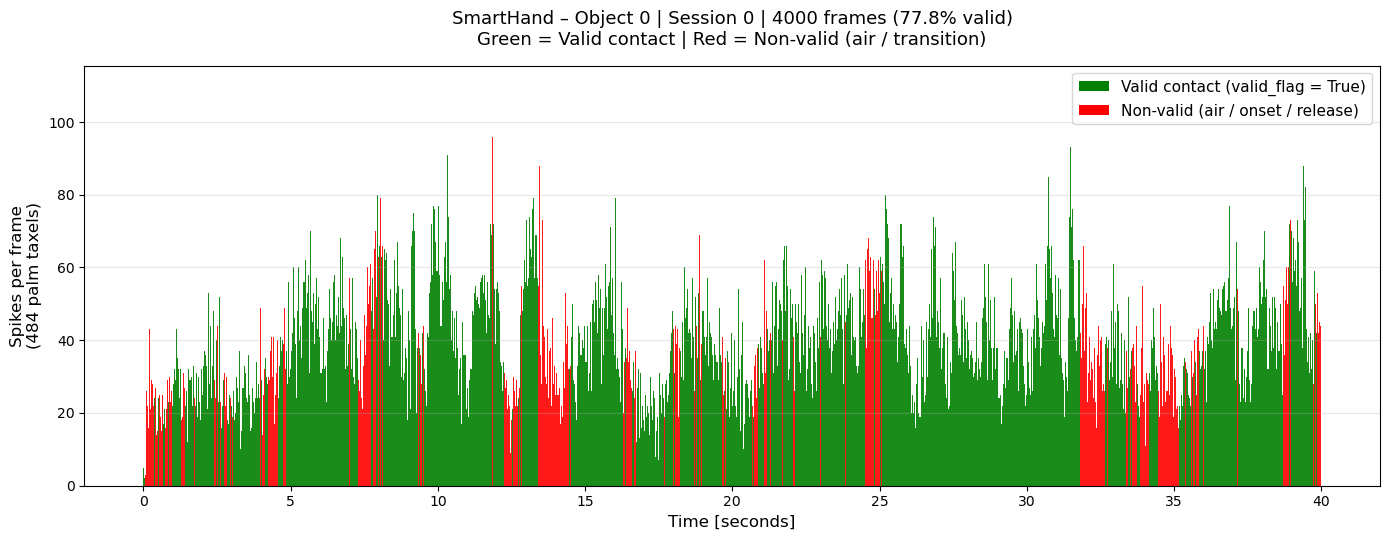

Plot ready – 161670 total spikes generated

Object 1, Session 0: 4000 frames (3371 valid, 629 non-valid)
  → Running bADM on 484 taxels...
 done


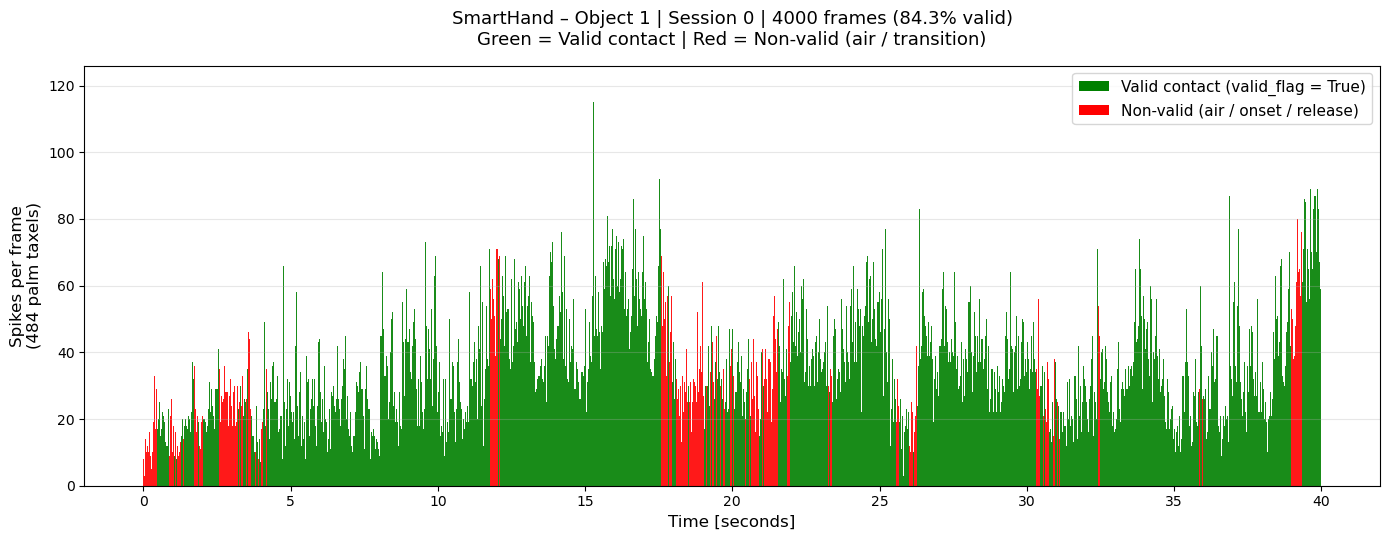

Plot ready – 142991 total spikes generated

Object 2, Session 0: 4000 frames (2863 valid, 1137 non-valid)
  → Running bADM on 484 taxels...
 done


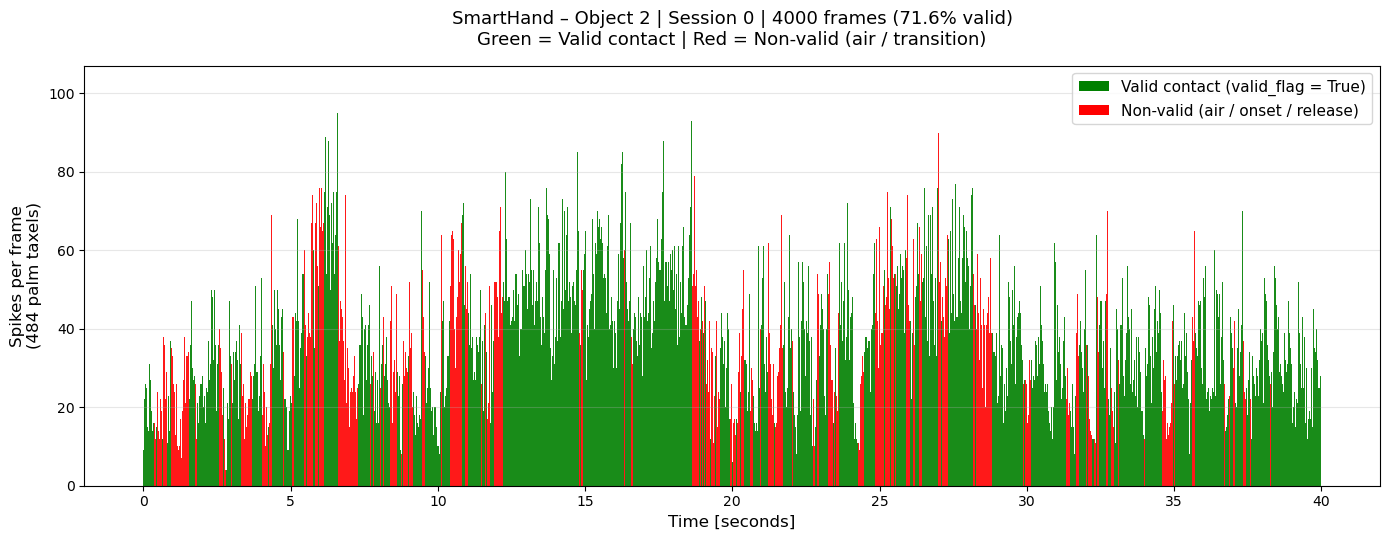

Plot ready – 151889 total spikes generated

Object 3, Session 0: 4000 frames (3106 valid, 894 non-valid)
  → Running bADM on 484 taxels...
 done


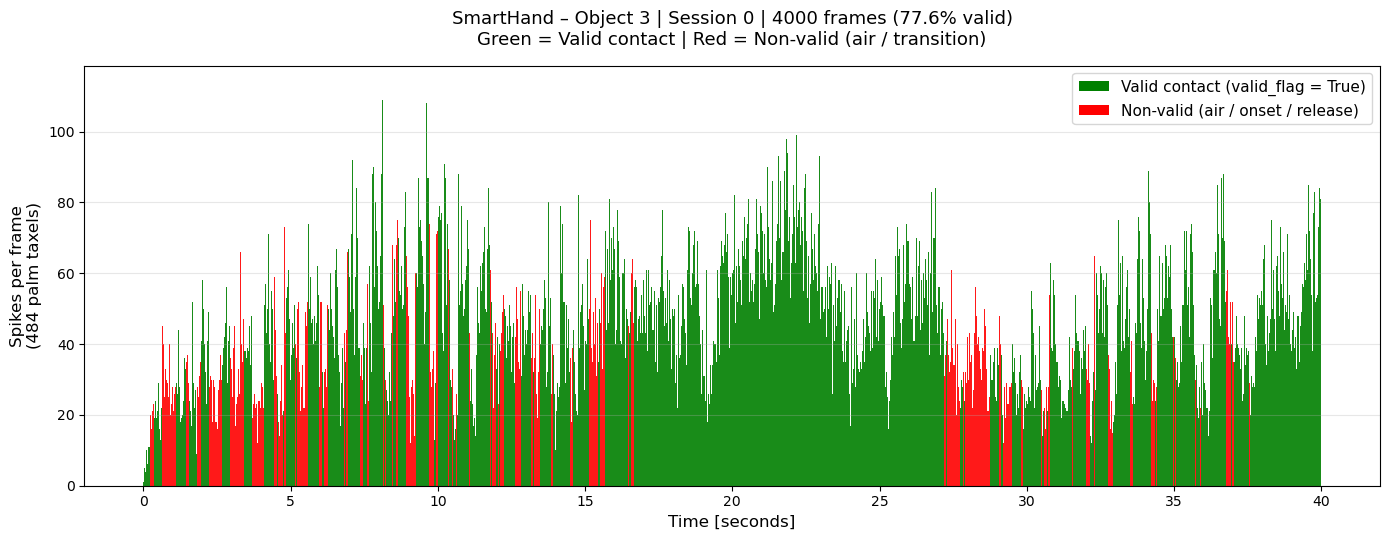

Plot ready – 182575 total spikes generated

Object 4, Session 0: 4000 frames (3226 valid, 774 non-valid)
  → Running bADM on 484 taxels...
 done


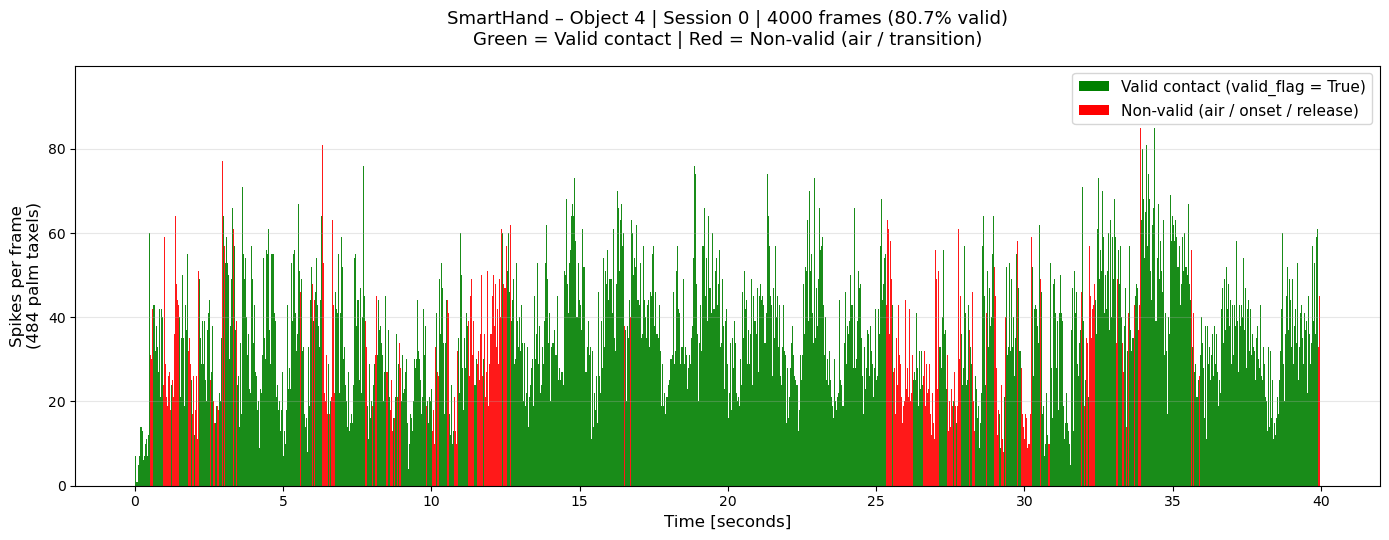

Plot ready – 142803 total spikes generated



In [ ]:
plot_spike_activity(object_id=0, session_id=0)   # ball
plot_spike_activity(object_id=1, session_id=0)   # battery
plot_spike_activity(object_id=2, session_id=0)   # bracket
plot_spike_activity(object_id=3, session_id=0)  # coin
plot_spike_activity(object_id=4, session_id=0)  # empty can


Object 6, Session 0: 4000 frames (3352 valid, 648 non-valid)
  → Running bADM on 484 taxels...
 done


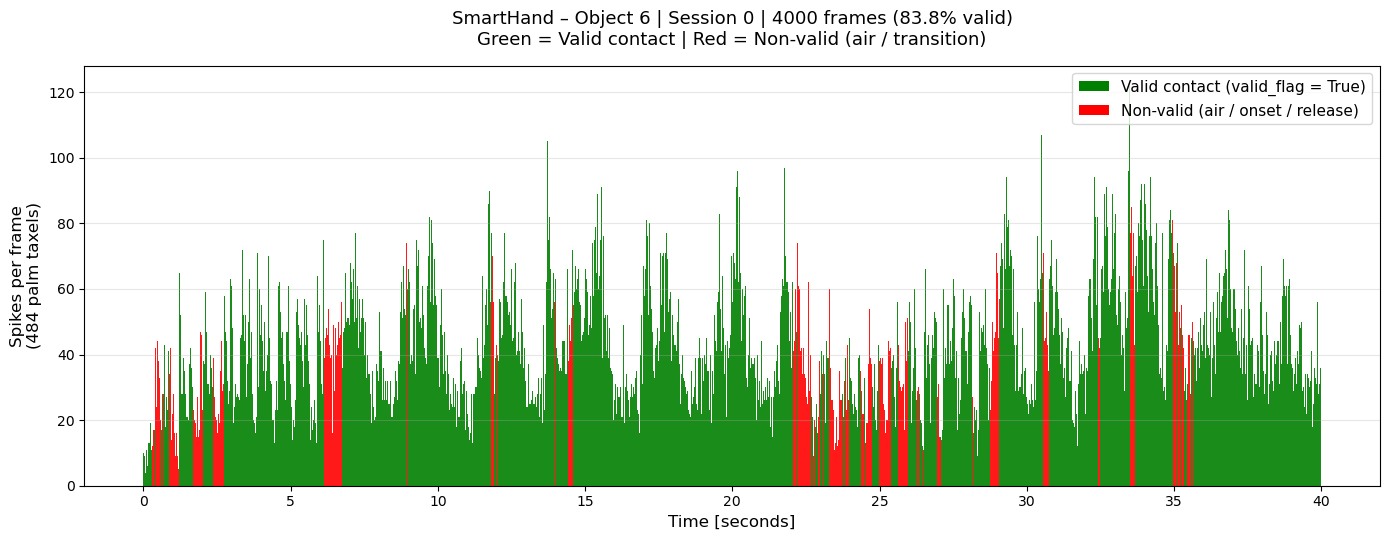

Plot ready – 170935 total spikes generated



In [5]:
plot_spike_activity(object_id=6, session_id=0)  # empty can
